In [1]:
%load_ext autoreload
%autoreload 2

from pyclarify import ClarifyClient, query, SignalInfo, DataFrame
import matplotlib.pyplot as plt
from forecast_clarify.main import *

In [2]:
client = ClarifyClient('../data/credentials/credentials_ow_persistence.json')

response = client.select_items(include_dataframe=False,limit=50)
item_dict = response.result.items
for item_id, meta_data in item_dict.items():
  print(f"ID: {item_id} \t Name: {meta_data.name}")

ID: c983nc7qfsjfsngo9qe0 	 Name: Average Wind Speed
ID: c983nc7qfsjfsngo9qeg 	 Name: NASDAQ SUP3_4
ID: c983nc7qfsjfsngo9qf0 	 Name: NASDAQ SUP4_5
ID: c983nc7qfsjfsngo9qfg 	 Name: NASDAQ SUP5_6
ID: c983nc7qfsjfsngo9qg0 	 Name: Sun State
ID: c983nc7qfsjfsngo9qgg 	 Name: Moon State
ID: c983nc7qfsjfsngo9qh0 	 Name: Wind Speed
ID: c983nc7qfsjfsngo9qhg 	 Name: Air Temperature
ID: c983nc7qfsjfsngo9qi0 	 Name: Sea Temperature
ID: c983nc7qfsjfsngo9qig 	 Name: Has In Feed Treatment 
ID: c983nc7qfsjfsngo9qj0 	 Name: Has Cleaner Fish Deployed 
ID: c983nc7qfsjfsngo9qjg 	 Name: Avg Stationary Lice 
ID: c983nc7qfsjfsngo9qk0 	 Name: Avg Mobile Lice 
ID: c983nc7qfsjfsngo9qkg 	 Name: Avg Adult Female Lice 
ID: c983nc7qfsjfsngo9ql0 	 Name: Has Mechanical Removal 
ID: c983nc7qfsjfsngo9qlg 	 Name: Sea Temperature 
ID: c983nc7qfsjfsngo9qm0 	 Name: Has Bath Treatment 
ID: c983nc7qfsjfsngo9qmg 	 Name: Sea level - Prediction
ID: c983nc7qfsjfsngo9qn0 	 Name: Sea level - Observation
ID: ca3lg94pllna3qe8aoeg 	 Na

In [3]:
item_id = ["ca8dhakpllnee2k58qfg"]

filter = query.Filter(fields={"id": query.In(value=item_id)})
response_unfiltered = client.select_items(
    filter = filter,
    include_metadata = True,
    include_dataframe = True,
    not_before = "2022-07-01T00:00:00Z",
    before = datetime.today()
)
print(response_unfiltered.result.data.times[-1])
# the data (at least for this item) is available with a lag of only two hours

2022-08-31 07:44:30+00:00


In [4]:
response_filtered = client.select_items(
    filter = filter,
    include_metadata = True,
    include_dataframe = True,
    not_before = "2019-05-01T00:00:00Z",
    before = datetime.today(),
    rollup = "P7DT"
)
# question: is the time tag that comes out of the rollup the center of the window?

st3m_langoey = response_filtered.result.data.to_pandas()
print(st3m_langoey.index[-10:])

DatetimeIndex(['2022-05-16 00:00:00+00:00', '2022-05-23 00:00:00+00:00',
               '2022-05-30 00:00:00+00:00', '2022-06-06 00:00:00+00:00',
               '2022-06-13 00:00:00+00:00', '2022-06-20 00:00:00+00:00',
               '2022-06-27 00:00:00+00:00', '2022-07-04 00:00:00+00:00',
               '2022-07-11 00:00:00+00:00', '2022-07-18 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


In [5]:
response_filtered_1D = client.select_items(
    filter = filter,
    include_metadata = True,
    include_dataframe = True,
    not_before = "2019-05-01T00:00:00Z",
    before = datetime.today(),
    rollup = "P1DT"
)
# question: is the time tag that comes out of the rollup the center of the window?

st3m_langoey_daily = response_filtered_1D.result.data.to_pandas()
print(st3m_langoey_daily.index[-10:])

DatetimeIndex(['2022-07-14 00:00:00+00:00', '2022-07-15 00:00:00+00:00',
               '2022-07-16 00:00:00+00:00', '2022-07-17 00:00:00+00:00',
               '2022-07-18 00:00:00+00:00', '2022-07-19 00:00:00+00:00',
               '2022-07-20 00:00:00+00:00', '2022-07-21 00:00:00+00:00',
               '2022-07-22 00:00:00+00:00', '2022-07-23 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


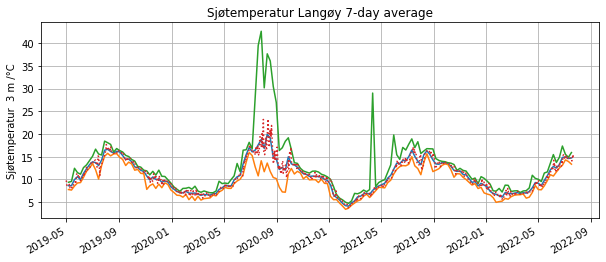

In [6]:
f,ax = plt.subplots(figsize=(10,4))
st3m_langoey.ca8dhakpllnee2k58qfg_avg.plot(ax=ax)
st3m_langoey.ca8dhakpllnee2k58qfg_min.plot(ax=ax)
st3m_langoey.ca8dhakpllnee2k58qfg_max.plot(ax=ax)
st3m_langoey_daily.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,ls='dotted')
ax.grid()
ax.set_ylabel('{0:s}  {1:s} /{2:s}'.format(
        response_unfiltered.result.items[item_id[0]].name,
        response_unfiltered.result.items[item_id[0]].labels['depth'][0],
        response_unfiltered.result.items[item_id[0]].engUnit
    )
);
ax.set_title('{0:s} {1:s} 7-day average'.format(
        response_unfiltered.result.items[item_id[0]].name,
        response_unfiltered.result.items[item_id[0]].labels['site'][0]
    )
);

### Compute seasonal cycle

In [22]:
SC = seas_cycle(st3m_langoey.ca8dhakpllnee2k58qfg_avg,nharm=3)
SC.fit()
SC.training_anomalies()

SC_1 = seas_cycle(st3m_langoey_daily.ca8dhakpllnee2k58qfg_avg)
SC_1.fit()
SC_1.training_anomalies()

SC_varharm = seas_cycle(st3m_langoey.ca8dhakpllnee2k58qfg_avg,nharm=1)
SC_varharm.fit()
SC_varharm.training_anomalies()

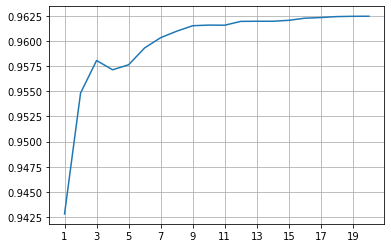

In [18]:
corr = []
for harm in range(1,21):

    SC_varharm = seas_cycle(st3m_langoey.ca8dhakpllnee2k58qfg_avg,nharm=harm)
    SC_varharm.fit()
    SC_varharm.training_anomalies()

    corr.append(np.corrcoef(SC.absolute_vals.ca8dhakpllnee2k58qfg_avg.values,SC_varharm.sc_exp_doy.ca8dhakpllnee2k58qfg_avg.values)[0,1])

corr = np.array(corr)

plt.plot(np.arange(1,21),corr)
plt.xticks(np.arange(1,21,2))
plt.grid()

(array([ 3.,  9., 29., 49., 40., 24.,  8.,  1.,  3.,  1.]),
 array([-3.13432696, -2.37827237, -1.62221778, -0.86616318, -0.11010859,
         0.645946  ,  1.40200059,  2.15805518,  2.91410977,  3.67016436,
         4.42621896]),
 <BarContainer object of 10 artists>)

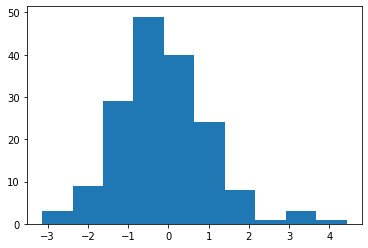

In [23]:
plt.hist(SC_varharm.anomalies.ca8dhakpllnee2k58qfg_avg.values)

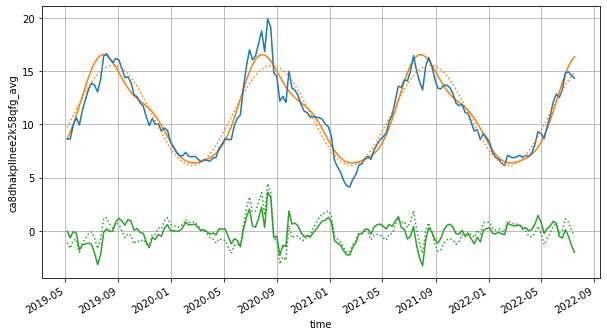

In [27]:
f,ax = plt.subplots(figsize=(10,5))

SC.sc_exp_doy.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C1')
SC.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C0')
SC.anomalies.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C2')

SC_varharm.sc_exp_doy.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,ls='dotted',color='C1')
# SC_varharm.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,ls='dotted')
SC_varharm.anomalies.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,ls='dotted',color='C2')

ax.grid()

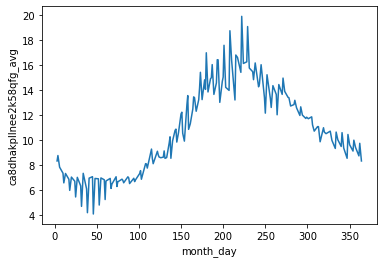

In [37]:
SC.abs_doy_mean.ca8dhakpllnee2k58qfg_avg.plot()

In [27]:
runstd = np.zeros_like(SC.anomalies.ca8dhakpllnee2k58qfg_avg.values)
for i in range(15,len(SC.anomalies.ca8dhakpllnee2k58qfg_avg)-14):
    runstd[i] = SC.anomalies.ca8dhakpllnee2k58qfg_avg.values[i-15:i+16].std()

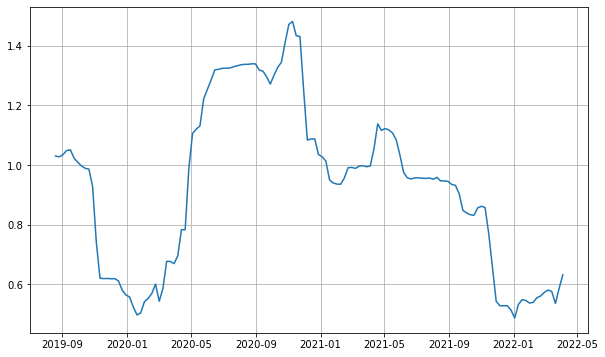

In [33]:
plt.figure(figsize=(10,6))
plt.plot(SC.anomalies.ca8dhakpllnee2k58qfg_avg.time.values[15:-15],runstd[15:-15])
plt.grid()

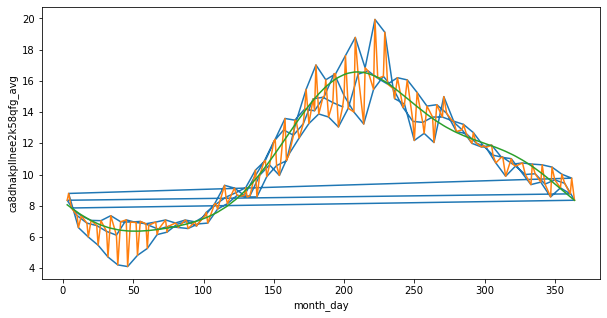

In [28]:
f,ax = plt.subplots(figsize=(10,5))
SC.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(x='month_day',ax=ax)
SC.abs_doy_mean.ca8dhakpllnee2k58qfg_avg.plot(ax=ax)
SC.mean_sc.ca8dhakpllnee2k58qfg_avg.plot(ax=ax)
# SC_1.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(x='month_day',ax=ax)
# SC_1.abs_doy_mean.ca8dhakpllnee2k58qfg_avg.plot(ax=ax)
# SC_1.mean_sc.ca8dhakpllnee2k58qfg_avg.plot(ax=ax)

### Estimate lagged anomaly correlation ('fit' the model)

Use the anomalies to estimate lag correlations

In [29]:
anom_pers = persistence(lags=4)
anom_pers.fit(SC.anomalies.ca8dhakpllnee2k58qfg_avg)

### Make prediction

In [30]:
# prediction of the anomaly:
anom_pred = anom_pers.predict(SC.anomalies.ca8dhakpllnee2k58qfg_avg.isel(time=-1))

# prediction of seasonal cycle:
sc_pred = SC.predict(anom_pred.time_doy,time_name='lags')

abs_pred = anom_pred + sc_pred

### Plot this

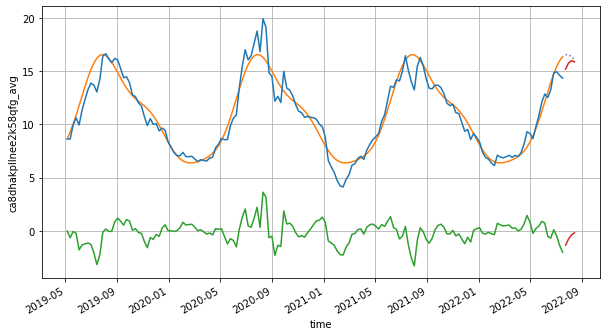

In [31]:
f,ax = plt.subplots(figsize=(10,5))

SC.sc_exp_doy.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C1')
SC.absolute_vals.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C0')
SC.anomalies.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='C2')

anom_pred.plot(ax=ax,x='time',color='C3')
sc_pred.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,x='time',color='C4',ls='dotted')
abs_pred.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,x='time',color='C3')

ax.grid()

### Write signal back to clarify

In [13]:
signal_name = '{0:s} forecast'.format(response_filtered.result.items[item_id[0]].name)
signal_desc = 'Persistence forecast of 7-day averages up to 4 weeks ahead'
signal_unit = response_filtered.result.items[item_id[0]].engUnit
signal_labels = {'data-source':['Persistence Model'],'site':response_filtered.result.items[item_id[0]].labels['site'],'depth':response_filtered.result.items[item_id[0]].labels['depth']}

In [14]:
# put forecast values into list:
fc_list = list(abs_pred.ca8dhakpllnee2k58qfg_avg.values)

# make list with corresponding dates:
time_list = list(abs_pred.time.values)

In [15]:
# Create a signal and write metadata to it
signal = SignalInfo(name = signal_name, description = signal_desc, engUnit = signal_unit, labels = signal_labels, sourceType = 'prediction')
client.save_signals(input_ids=['persistence_fc_test'], signals=[signal], create_only=False)
# Write data into a signal
data = DataFrame(series={'persistence_fc_test': fc_list}, times = time_list)
client.insert(data)


Response(jsonrpc='2.0', id='1', result=InsertResponse(signalsByInput={'persistence_fc_test': InsertSummary(id='cb45n4spllneem6kh450', created=False)}), error=None)